# set up spectrograms

In [2]:
%reset
%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import collections 
import kde_spikephase as kd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns

from kde_spikephase import kde_spikephase_estimator_forarray
from mdl_eval_tools import bayes,kl,logloss
from pprint import pprint
from process_lfps import create_data_segments
from rayleigh_pr import rayleigh_pr
from scipy.signal import cwt, hilbert, find_peaks, morlet2
from scipy.stats import sem
from tqdm.notebook import tqdm

sns.set(font_scale=2,style='whitegrid')

pd.options.display.max_colwidth = 100

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
def get_neuron_cols(df,neuron_expression):
    """df: dataframe containing columns corresponding to neuron spiketimes"""
    
    pattern = re.compile(neuron_expression)
    neuron_cols = []
    for s in df.columns:

        matched = pattern.match(s)
        is_match = bool(matched)

        if is_match:

            neuron_cols.append(matched.string)
    
    return neuron_cols

def get_allowable_lfp_wires(neuron_id,split_on):
    """neuron_id: string, e.g. TETSPK53b
    split_on: string, e.g. 'K', you will use this to exclude the unit letter from neuron_id"""

    #figure out who is the corresponding LFP for this neuron, must be on same tetrode!
    unit_wirenum = neuron.split(split_on)[1]
    unit_wirenum = unit_wirenum[:-1]
    if len(unit_wirenum) > 2:
        unit_wirenum = unit_wirenum[:2]
    allow_wire = [int(unit_wirenum), int(unit_wirenum) + 1, int(unit_wirenum) + 2, int(unit_wirenum) + 3]
    allow_wire = [str(w) for w in allow_wire]
    allow_wire = ['0'+w if int(w)<10 else w for w in allow_wire]
    
    return allow_wire

def get_lfp_cols(df,lfp_expression):
    """df: dataframe containing columns corresponding to neuron spiketimes
    lfp_expression: string, e.g."""
#example lfp_expression =  "TETFP"+allow_wire[0]+"\Z|TETFP"+allow_wire[1]+"\Z|TETFP"+allow_wire[2]+"\Z|TETFP"+allow_wire[3]+"\Z"
        
    pattern = re.compile(lfp_expression)
    lfp_cols = []
    for s in df.columns:

        matched = pattern.match(s)
        is_match = bool(matched)

        if is_match:

            lfp_cols.append(matched.string)

    return lfp_cols

def zscore_spectrogram(raw_spec):
    """raw_spec: n x m, where n is frequencies and m is time--important 
                 because you need to make sure that you find the mean and std
                 across the time dimension"""
    
    nfreqs = np.size(raw_spec,0)
    ntimesamps = np.size(raw_spec,1)
    
    meanf = np.mean(np.abs(raw_spec),axis=1)
    stdf = np.std(np.abs(raw_spec),axis=1)
    
    z_spec = np.zeros((nfreqs,ntimesamps))
    for ind,m in enumerate(meanf):
        
        z_spec[ind,:] = (np.abs(raw_spec[ind,:]) - m) / stdf[ind]
        
        
    return z_spec

def compute_thetapeak_spectros(df,lfpname,pre_post_wintime,
                               plot_maxfreq,colormap,peak_morlet_freq,
                               fs,morlet_w,plot_raw_or_z,
                               cmin,cmax,plot_pre_post_wintime,
                               savefig
                              ): 
    """df: subsess = all_lfp[all_lfp['ratsession_id']==ratsession].dropna(axis=1)
           subcondition = subsess[subsess['odor_labels']==odor] 
       lfpname: e.g. 'TETFP21' 
       pre_post_wintime: scalar, e.g. 250
       plot_raw_or_z: 'raw' or 'zscored', to decide which plot to output"""
    
    peak_locs, _ = find_peaks(df[lfpname+'filt_theta'],height=0)
    
    #now that you have the locations of the peaks, you'll want to find the 250 ms before and after

    gather_dfs = []
    theta_winlabel = []
    count = 0
    for i in peak_locs:

        if (i - pre_post_wintime >= 0) & ((i + pre_post_wintime) <= df.shape[0]):

            theta_winlabel = np.repeat(count,df.shape[0])
            df['window_labels'] = theta_winlabel
            gather_dfs.append(df.iloc[i-pre_post_wintime:i+pre_post_wintime])

            count += 1

    thetapeak_df = pd.concat(gather_dfs)
    
    #now compute the spectrogram for each window, then average them
    window_labels = list(set(thetapeak_df['window_labels']))
    
    #complex morlet wavelet params
    fs = fs
    w = morlet_w
    t = np.arange(-pre_post_wintime,pre_post_wintime)
    freq = np.linspace(1, fs/2, peak_morlet_freq)
    widths = w*fs / (2*freq*np.pi)
    
    datalen = pre_post_wintime*2

    gather_theta_filts = np.zeros((max(window_labels)+1,datalen))
    gather_spectros = np.zeros((max(window_labels)+1,len(widths),datalen)) #this will break if you change the nperseg
    gather_z_spectros = np.zeros((max(window_labels)+1,len(widths),datalen))
    for window in window_labels: 

        subw = thetapeak_df[thetapeak_df['window_labels'] == window]

        #get the wavelet spectrograms
        sig = subw[lfpname].values
        cwtmatr = cwt(sig, morlet2, widths)
        gather_spectros[window,:] = np.abs(cwtmatr)

        #gather the zscored normalized versions too
        gather_z_spectros[window,:] = zscore_spectrogram(cwtmatr)

        #gather the theta-filtered signals
        gather_theta_filts[window,:] = subw[lfpname+'filt_theta'].values
        
    #now plot it!
    fig,ax=plt.subplots(figsize=(20,6))
    
    plotting_range = np.arange(plot_pre_post_wintime,3*plot_pre_post_wintime)
    if plot_raw_or_z == 'zscored': 

        t = np.arange(-plot_pre_post_wintime,plot_pre_post_wintime)
        meanspec = gather_z_spectros[:,:,plotting_range].mean(axis=0)
        
        if cmin == []:
        
            cmin = -meanspec.max()
            cmax = meanspec.max()
        
        g = ax.pcolormesh(t, freq, meanspec, 
                             cmap=colormap,vmin=cmin,vmax=cmax,
                             shading='gouraud')
    
    elif plot_raw_or_z == 'raw':
        t = np.arange(-plot_pre_post_wintime,plot_pre_post_wintime)
        meanspec = gather_spectros[:,:,plotting_range].mean(axis=0)
        
        if cmin == []:
        
            cmin = -meanspec.max()
            cmax = meanspec.max()
        
        g = ax.pcolormesh(t, freq, meanspec, 
                             cmap=colormap,
                             shading='gouraud')
        

    ax.set_ylim(1,plot_maxfreq)
    fig.colorbar(g)

    x = (subw.index[plotting_range] - min(subw.index[plotting_range])) - (max(subw.index[plotting_range] - min(subw.index[plotting_range]))/2)
    ax_ = ax.twinx()
    ax_.grid(False)
    ax_.plot(x,gather_theta_filts[:,plotting_range].mean(axis=0),color='white',linewidth=5)
    
    ax.set_xlim(t[0],t[-1])

    fig.tight_layout()
    
#     if savefig:
#         ratsession = df['ratsession_id'].iloc[0]
#         figname = ratsession + '_' + lfpname + '_meanspec_fullsession.pdf'
#         fig.savefig('figures_approach/spectrograms/'+figname)
    
    meantheta = gather_theta_filts[:,plotting_range].mean(axis=0)
    

    return meanspec, t, freq, meantheta



## make dataframes containing the phase of each rhythm along with the corresponding lfps

In [14]:
datapath = 'python_spkphase_odorsamp/'
files = os.listdir(datapath)
files = [f for f in files if not f.startswith('.')]
files = sorted(files)

gather_df = []
for file in tqdm(files,colour='cornflowerblue'): 
    
    ratsession_id = file.split('_')[0] + '_' + file.split('_')[1]
    
    df = pd.read_csv(os.path.join(datapath,file))
    odorsamp_df = df[df['trial_segment']=='dur']
    
    #find the lfp columns in this dataframe
    lfp_cols = get_lfp_cols(odorsamp_df,'TETFP\d{2}$')
    
    lfp_vars = []
    for lfpname in lfp_cols: 
        
        lfp = odorsamp_df[lfpname].values
        lfp_vars.append(pd.DataFrame({lfpname: lfp}))
    
      
    lfpdf = pd.concat(lfp_vars,axis=1)

    
    filtered_cols = get_lfp_cols(odorsamp_df,'TETFP\d{2}.')
    filtered_sigs = []
    for filtname in filtered_cols: 
 
        filtered = odorsamp_df[filtname].values
        filtered_sigs.append(pd.DataFrame({filtname: filtered.T}))
   
    filtdf = pd.concat(filtered_sigs,axis=1)

    
    phase_cols = []
    amp_cols = []
    for filtname in filtered_cols: 
        
        filtered = odorsamp_df[filtname].values
        analytic = hilbert(filtered)
        
        amp_varname = filtname.split('filt')[0] + 'amp_' + filtname.split('_')[1]   
        amps = np.abs(analytic)
        amp_cols.append(pd.DataFrame({amp_varname: amps.T}))
        

        if filtname.split('_')[1] == 'theta':
            
            phase_varname = filtname.split('filt')[0] + 'phase_' + filtname.split('_')[1]
            
            phases = np.arctan2(analytic.imag,filtered)
            phase_cols.append(pd.DataFrame({phase_varname: phases.T}))

    phasedf = pd.concat(phase_cols,axis=1)

    
    if len(amp_cols) > 1: 
        ampdf = pd.concat(amp_cols,axis=1)
    else:
        ampdf = amp_cols

    #add the metadata in case you want to subset by it later
    odor_block_labels = odorsamp_df['odor_block_labels'].values
    odor_labels = odorsamp_df['odor_labels'].values
    pos_labels = odorsamp_df['pos_labels'].values
    trial_labels = odorsamp_df['trial_labels'].values
    quarter_labels = odorsamp_df['quarter_labels'].values
    accuracies = odorsamp_df['accuracy'].values
    
    #organize your metadata
    metadatadf = pd.DataFrame({'ratsession_id': np.repeat(ratsession_id,len(trial_labels)),
                               'odor_block_labels': odor_block_labels,
                               'quarter_labels': quarter_labels,
                               'odor_labels': odor_labels,
                               'pos_labels': pos_labels,
                               'accuracy': accuracies,
                               'trial_labels': trial_labels
                              })
    
    #now put them all together 
    #now put them all together 
    tmp = pd.concat([metadatadf,lfpdf,phasedf,filtdf,ampdf],axis=1)
    gather_df.append(tmp)

all_lfp = pd.concat(gather_df)

  0%|          | 0/18 [00:00<?, ?it/s]

## spectrograms: how do the high frequencies organize across theta cycles? 


In [ ]:
ratsession = 'LH09_D10'
subsess = all_lfp[all_lfp['ratsession_id']==ratsession].dropna(axis=1)

lfpname = 'TETFP53'

pre_post_wintime = 500
plot_maxfreq = 100
colormap = 'bwr'
peak_morlet_freq = 250
fs = 1000
morlet_w = 4
plot_raw_or_z = 'zscored'
cmax =[]
cmin = []
plot_pre_post_wintime = 250

meanspec, t, freq, meantheta = compute_thetapeak_spectros(subsess,
                                                          lfpname,
                                                          pre_post_wintime,
                                                          plot_maxfreq,
                                                          colormap,
                                                          peak_morlet_freq,
                                                          fs,morlet_w,
                                                          plot_raw_or_z,
                                                          cmin,cmax,
                                                          plot_pre_post_wintime,0)
                           
                           
                           

In [1]:
# fig,ax = plt.subplots(figsize=(20,6))



# g = ax.pcolormesh(t, freq, meanspec, 
#                   cmap=colormap,vmin=-meanspec.max(),
#                   vmax=meanspec.max(),
#                   shading='gouraud')
# ax.set_ylim(1,100)
# fig.colorbar(g)

# ax_ = ax.twinx()
# ax_.grid(False)
# ax_.plot(t,meantheta,color='white',linewidth=5)

# ax.set_xlim(t[0],t[-1])

# fig.tight_layout()
# fig.set_rasterized(True)
# figname = ratsession + '_' + lfpname


In [ ]:
ratsession = 'LH16_D25'
subsess = all_lfp[all_lfp['ratsession_id']==ratsession].dropna(axis=1)

lfpname = 'TETFP33'

pre_post_wintime = 500
plot_maxfreq = 100
colormap = 'bwr'
peak_morlet_freq = 250
fs = 1000
morlet_w = 4
plot_raw_or_z = 'zscored'
cmax =[]
cmin = []
plot_pre_post_wintime = 250

meanspec, t, freq, meantheta = compute_thetapeak_spectros(subsess,
                                                          lfpname,
                                                          pre_post_wintime,
                                                          plot_maxfreq,
                                                          colormap,
                                                          peak_morlet_freq,
                                                          fs,morlet_w,
                                                          plot_raw_or_z,
                                                          cmin,cmax,
                                                          plot_pre_post_wintime,0)
                           
                           
                           

In [ ]:
ratsession = 'LH08_D32'
subsess = all_lfp[all_lfp['ratsession_id']==ratsession].dropna(axis=1)

lfpname = 'TETFP09'

pre_post_wintime = 500
plot_maxfreq = 100
colormap = 'bwr'
peak_morlet_freq = 250
fs = 1000
morlet_w = 4
plot_raw_or_z = 'zscored'
cmax =[]
cmin = []
plot_pre_post_wintime = 250

meanspec, t, freq, meantheta = compute_thetapeak_spectros(subsess,
                                                          lfpname,
                                                          pre_post_wintime,
                                                          plot_maxfreq,
                                                          colormap,
                                                          peak_morlet_freq,
                                                          fs,morlet_w,
                                                          plot_raw_or_z,
                                                          cmin,cmax,
                                                          plot_pre_post_wintime,0)
                           
                           

ratsession = 'LH03_D18'
subsess = all_lfp[all_lfp['ratsession_id']==ratsession].dropna(axis=1)

lfpname = 'TETFP87'

pre_post_wintime = 500
plot_maxfreq = 100
colormap = 'bwr'
peak_morlet_freq = 250
fs = 1000
morlet_w = 4
plot_raw_or_z = 'zscored'
cmax =[]
cmin = []
plot_pre_post_wintime = 250

meanspec, t, freq, meantheta = compute_thetapeak_spectros(subsess,
                                                          lfpname,
                                                          pre_post_wintime,
                                                          plot_maxfreq,
                                                          colormap,
                                                          peak_morlet_freq,
                                                          fs,morlet_w,
                                                          plot_raw_or_z,
                                                          cmin,cmax,
                                                          plot_pre_post_wintime,0)
                           
                           
                           

### check stability of z-scored spectros across different LFP snippets from a session
take a sampling of the *top trials* with the highest high gamma amplitude, and then the ten trials with *lowest* high gamma amplitudes, and then plot the corresponding meanspecs; to check that the pattern isn't a weird property of weighting trials with large and weak high gamma amplitudes equally when we take the z-scores and average across them

In [ ]:
ratsession = 'LH08_D32'
subsess = all_lfp[all_lfp['ratsession_id']==ratsession].dropna(axis=1)
lfpname = 'TETFP09'

highgamma_tmp = subsess.groupby(['odor_block_labels','trial_labels']).mean()[lfpname+'filt_highgamma'].reset_index()
inds = np.where(highgamma_tmp[lfpname+'filt_highgamma'] >= highgamma_tmp[lfpname+'filt_highgamma'].mean())
block_trials = highgamma_tmp.iloc[inds][['odor_block_labels','trial_labels']].values


gather_subtrials = []
for block_trial in block_trials: 
    
    block = block_trial[0]
    trial = block_trial[1]
        
    subtrial = subsess[(subsess['odor_block_labels']==block)&(subsess['trial_labels']==trial)]
    
    gather_subtrials.append(subtrial)
    
subset = pd.concat(gather_subtrials)

pre_post_wintime = 500
plot_maxfreq = 100
colormap = 'bwr'
peak_morlet_freq = 250
fs = 1000
morlet_w = 4
plot_raw_or_z = 'zscored'
cmax =[]
cmin = []
plot_pre_post_wintime = 250

meanspec, t, freq, meantheta = compute_thetapeak_spectros(subset,
                                                          lfpname,
                                                          pre_post_wintime,
                                                          plot_maxfreq,
                                                          colormap,
                                                          peak_morlet_freq,
                                                          fs,morlet_w,
                                                          plot_raw_or_z,
                                                          cmin,cmax,
                                                          plot_pre_post_wintime,0)
                           
                           

In [ ]:
ratsession = 'LH08_D32'
subsess = all_lfp[all_lfp['ratsession_id']==ratsession].dropna(axis=1)
lfpname = 'TETFP09'

highgamma_tmp = subsess.groupby(['odor_block_labels','trial_labels']).mean()[lfpname+'filt_highgamma'].reset_index()
inds = np.where(highgamma_tmp[lfpname+'filt_highgamma'] < highgamma_tmp[lfpname+'filt_highgamma'].mean())
block_trials = highgamma_tmp.iloc[inds][['odor_block_labels','trial_labels']].values


gather_subtrials = []
for block_trial in block_trials: 
    
    block = block_trial[0]
    trial = block_trial[1]
        
    subtrial = subsess[(subsess['odor_block_labels']==block)&(subsess['trial_labels']==trial)]
    
    gather_subtrials.append(subtrial)
    
subset = pd.concat(gather_subtrials)

pre_post_wintime = 500
plot_maxfreq = 100
colormap = 'bwr'
peak_morlet_freq = 250
fs = 1000
morlet_w = 4
plot_raw_or_z = 'zscored'
cmax =[]
cmin = []
plot_pre_post_wintime = 250

meanspec, t, freq, meantheta = compute_thetapeak_spectros(subset,
                                                          lfpname,
                                                          pre_post_wintime,
                                                          plot_maxfreq,
                                                          colormap,
                                                          peak_morlet_freq,
                                                          fs,morlet_w,
                                                          plot_raw_or_z,
                                                          cmin,cmax,
                                                          plot_pre_post_wintime,0)

### single trial spectrograms

In [15]:
ratsession = 'LH08_D32'
subsess = all_lfp[all_lfp['ratsession_id']==ratsession].dropna(axis=1)

print(set(subsess[subsess['odor_labels']==12]['trial_labels']))
print(set(subsess[subsess['odor_labels']==12]['odor_block_labels']))

{1, 2, 3, 8, 9, 10, 13, 14, 16, 17, 20, 21}
{2}


In [16]:
subtrial.columns

Index(['ratsession_id', 'odor_block_labels', 'quarter_labels', 'odor_labels',
       'pos_labels', 'accuracy', 'trial_labels', 'TETFP53', 'TETFP21',
       'TETFP09', 'TETFP53phase_theta', 'TETFP21phase_theta',
       'TETFP09phase_theta', 'TETFP53filt_theta', 'TETFP53filt_beta',
       'TETFP53filt_lowgamma', 'TETFP53filt_highgamma', 'TETFP21filt_theta',
       'TETFP21filt_beta', 'TETFP21filt_lowgamma', 'TETFP21filt_highgamma',
       'TETFP09filt_theta', 'TETFP09filt_beta', 'TETFP09filt_lowgamma',
       'TETFP09filt_highgamma', 'TETFP53amp_theta', 'TETFP53amp_beta',
       'TETFP53amp_lowgamma', 'TETFP53amp_highgamma', 'TETFP21amp_theta',
       'TETFP21amp_beta', 'TETFP21amp_lowgamma', 'TETFP21amp_highgamma',
       'TETFP09amp_theta', 'TETFP09amp_beta', 'TETFP09amp_lowgamma',
       'TETFP09amp_highgamma'],
      dtype='object')

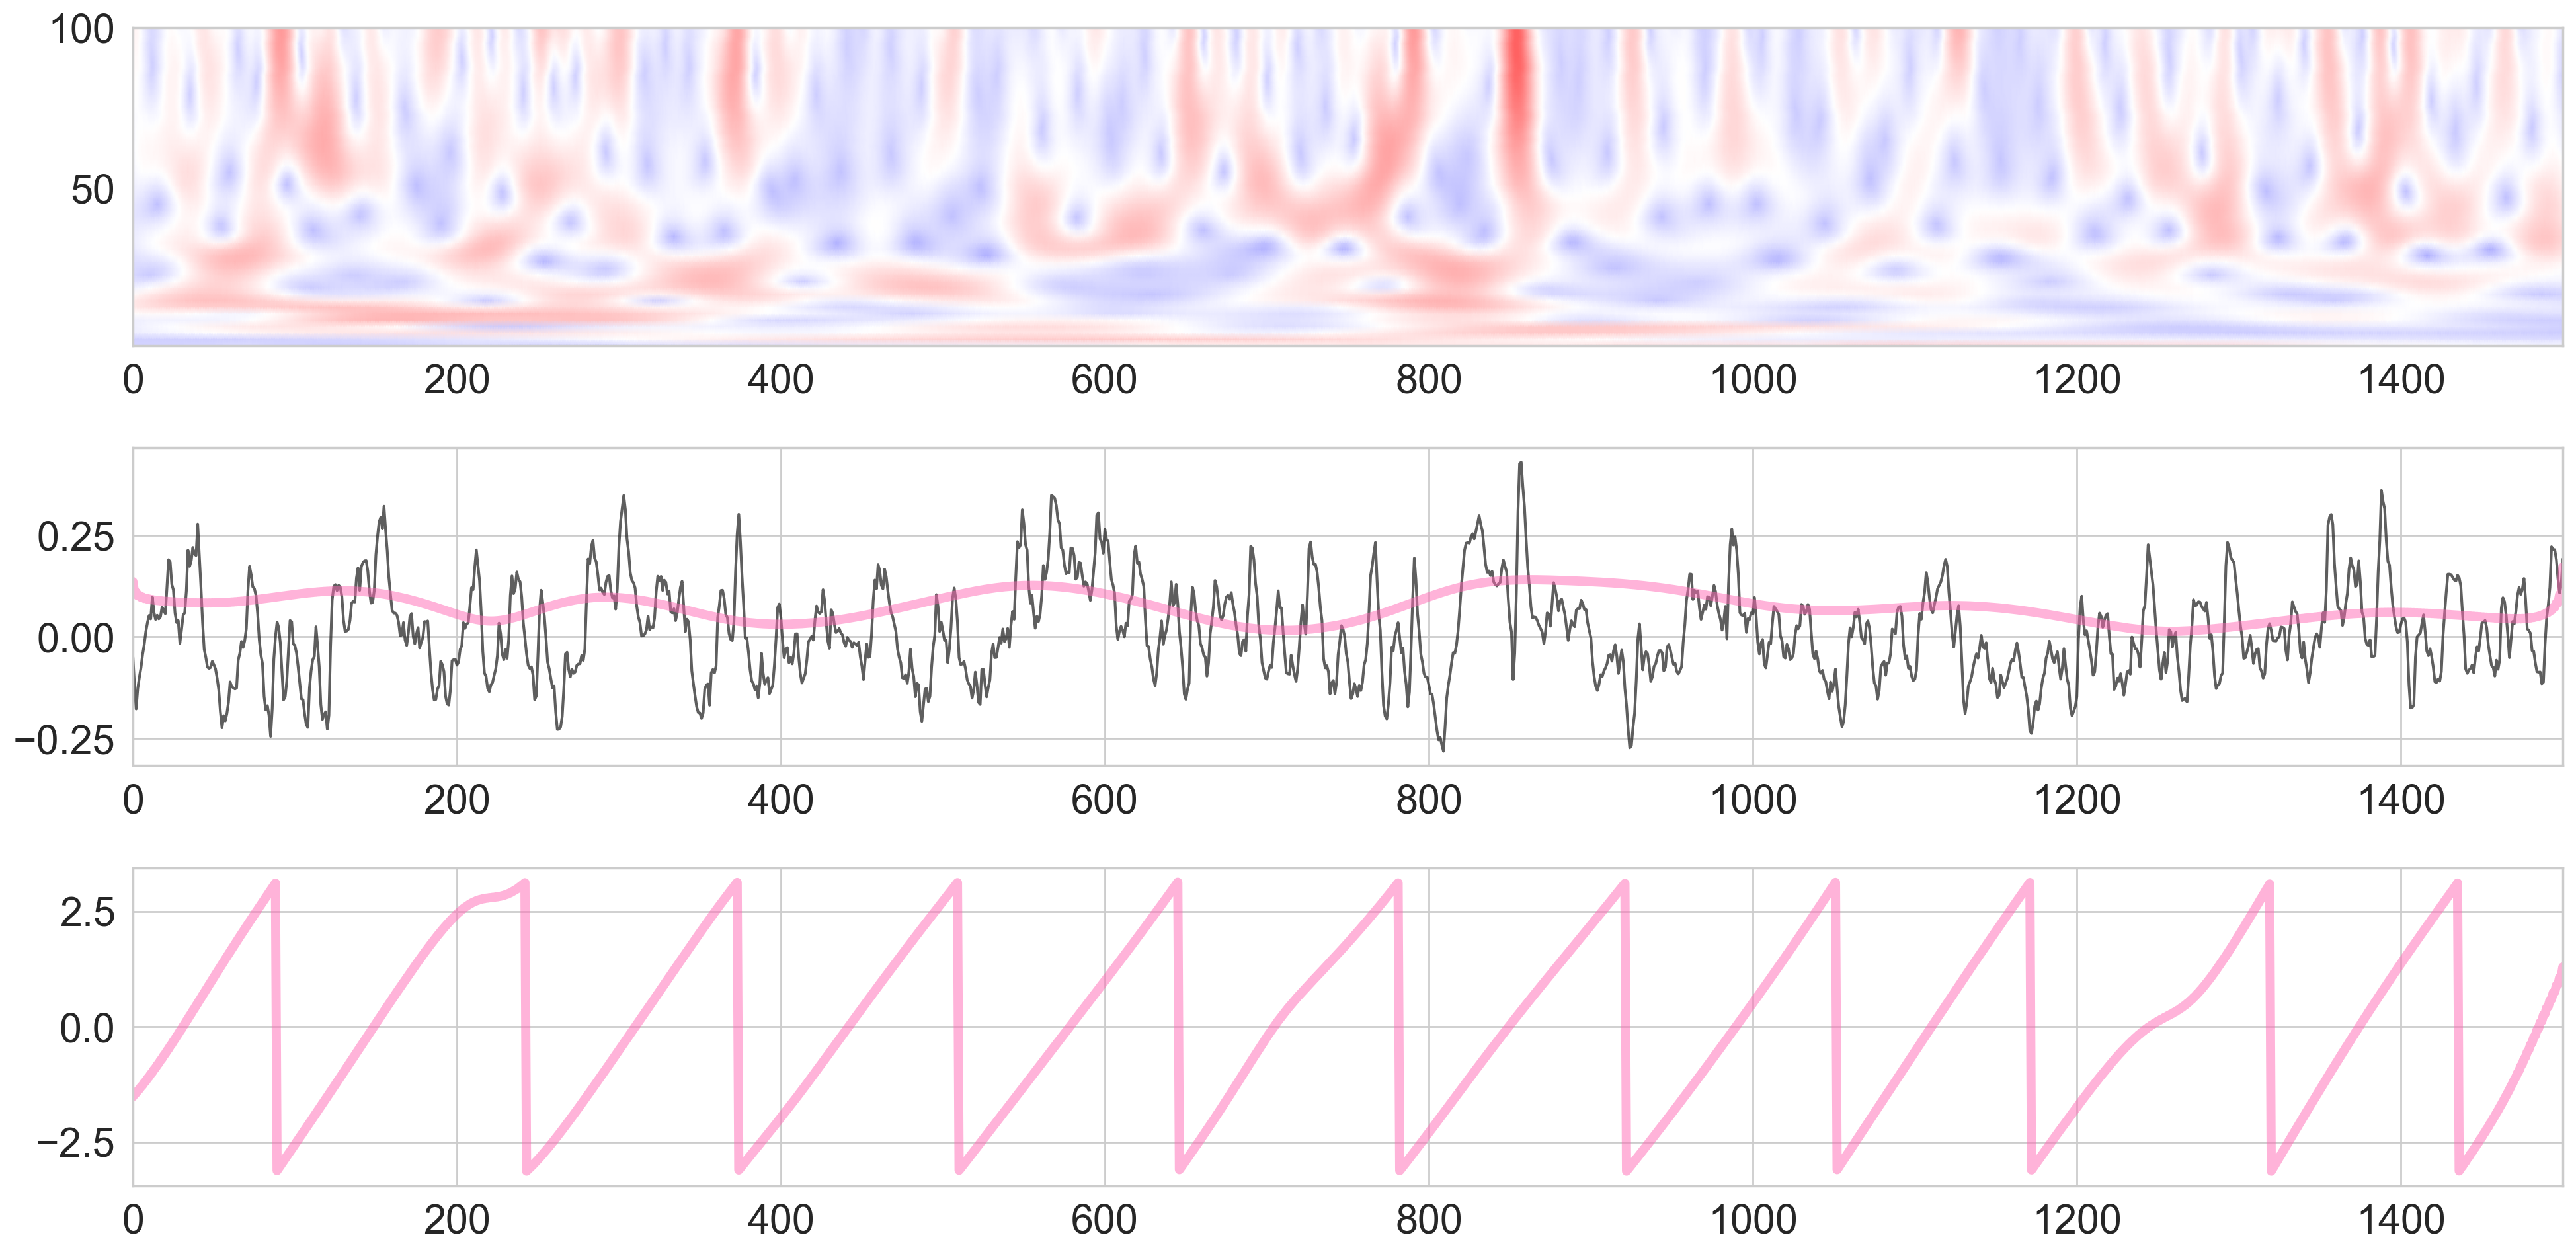

In [17]:
lfpname = 'TETFP09'
odorblock, trial = 2, 7

subtrial = subsess[(subsess['odor_block_labels'] == odorblock) & (subsess['trial_labels']==trial)]

#complex morlet wavelet params
datalen = subtrial.shape[0]
fs = 1000
w = 4
peak_morlet_freq = 250
colormap = 'bwr'

t = np.arange(0,datalen)
freq = np.linspace(1, fs/2, peak_morlet_freq)
widths = w*fs / (2*freq*np.pi)

#get the wavelet spectrograms
sig = subtrial[lfpname].values
spec = cwt(sig, morlet2, widths)

zspec = zscore_spectrogram(spec)

cmin = -zspec.max()
cmax = zspec.max()


fig, ax = plt.subplots(3,1, figsize=(20,10))



g = ax[0].pcolormesh(t, freq, zspec, 
                  cmap=colormap,vmin=cmin,vmax=cmax,
                  shading='gouraud')

# fig.colorbar(g,ax=ax[0])

# g = ax[0].pcolormesh(t, freq, np.abs(spec), 
#                   cmap='jet',vmin=np.abs(spec).min(),vmax=np.abs(spec).max(),
#                   shading='gouraud')

ax[0].set_ylim(1,100)

ax[1].plot(t,subtrial[lfpname].values,color='k',alpha=0.7)
# ax[1].plot(t,subtrial[lfpname+'filt_theta'],color='hotpink',linewidth=6,alpha=0.6)

ax[1].set_xlim(t[0],t[-1])
ax[1].plot(t,subtrial[lfpname+'amp_theta'].values,color='hotpink',alpha=0.5,linewidth=5)

ax[2].plot(t,subtrial[lfpname+'phase_theta'].values,color='hotpink',alpha=0.5,linewidth=5)
ax[2].set_xlim(t[0],t[-1])
# ax[1].vlines(x = spiketimes, ymin=-0.4,ymax=-.2,color='k')

fig.tight_layout()

# fig.set_rasterized(True)
figname = ratsession + '_' + lfpname + '_odorblock' + str(odorblock) + '_trial' + str(trial)
# fig.savefig('figures_odor/zspec_singletrial'+figname+'.pdf')

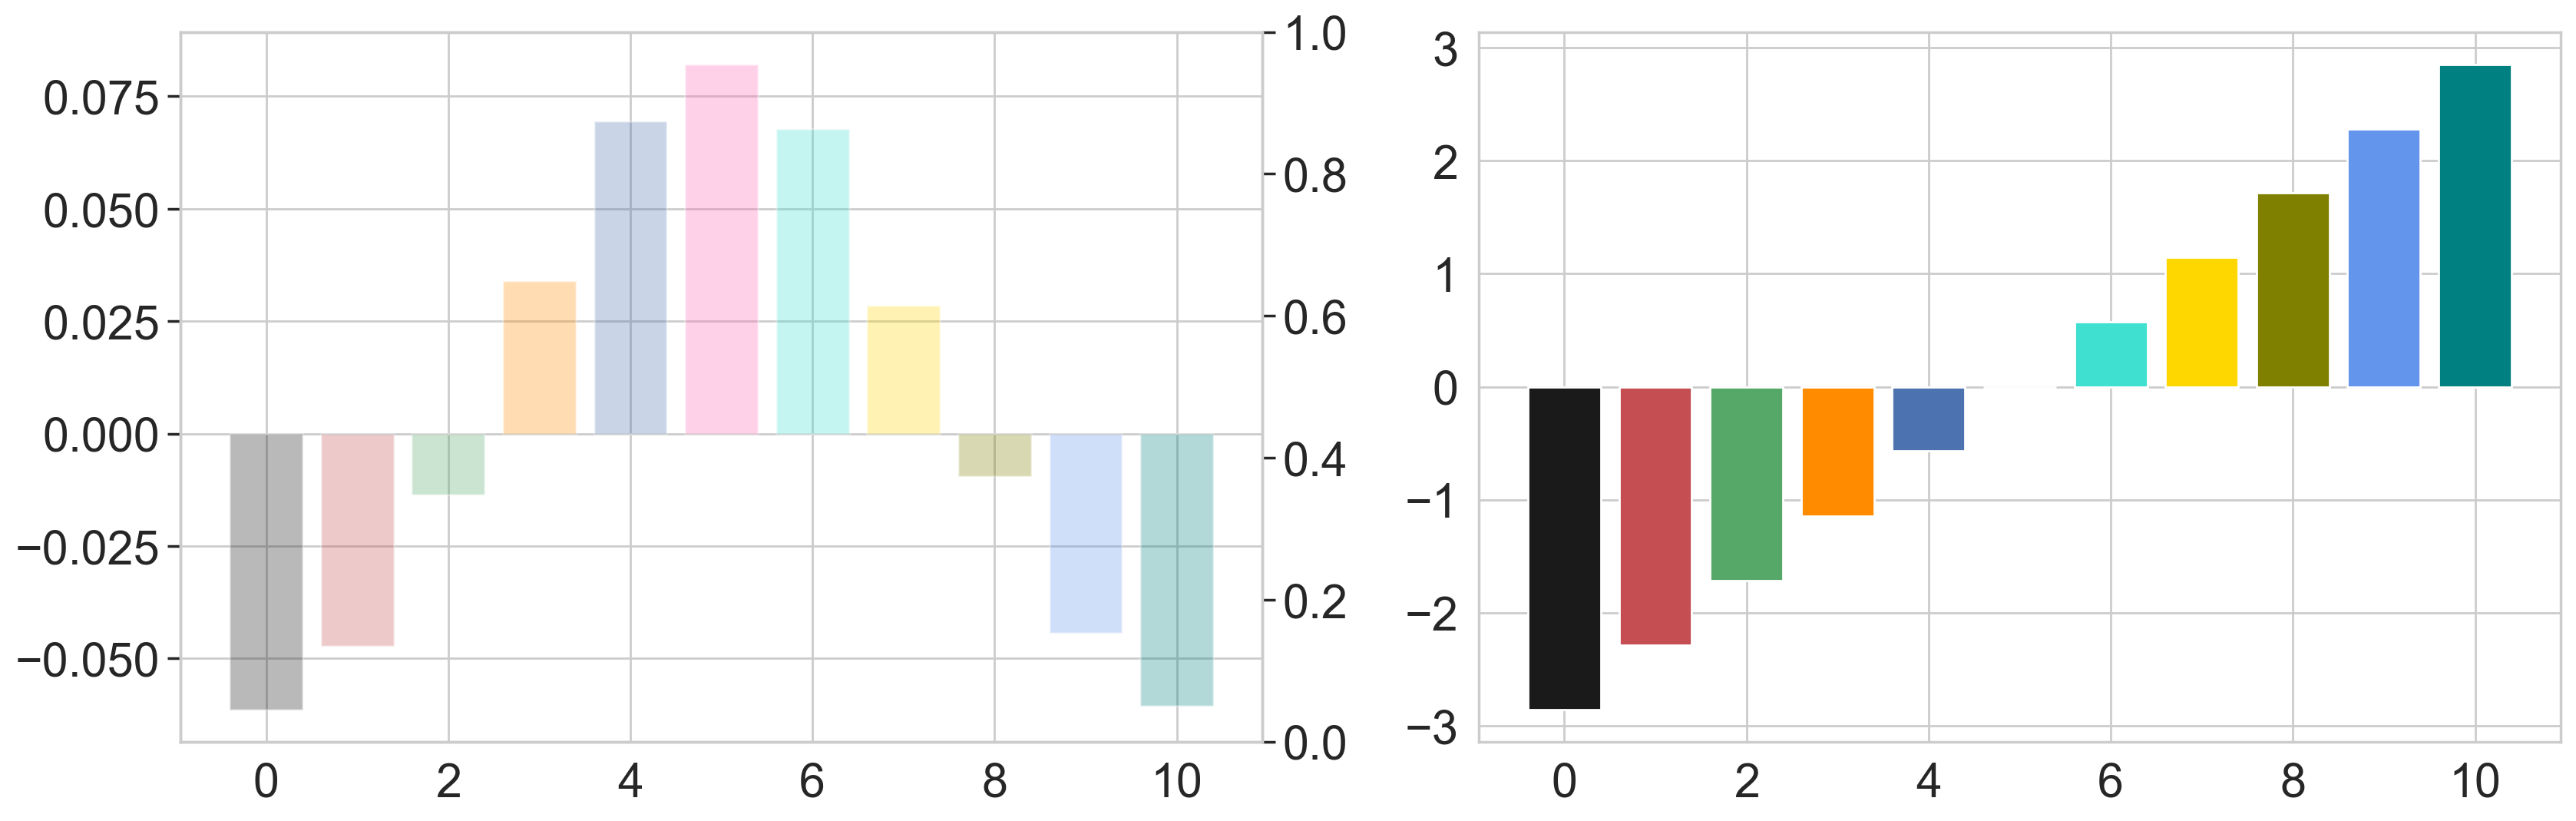

In [20]:
nbins = 12
phase_bins = np.linspace(-np.pi,np.pi,nbins)
bin_labels = [int(i) for i in np.linspace(0,nbins-2,nbins-1)]

subsess['phase_bins'] = pd.cut(x=subsess[lfpname + 'phase_theta'],
                               right=True,
                               bins=phase_bins,
                               labels=bin_labels,
                               include_lowest=True
                              )

tmp = pd.cut(x=subsess[lfpname + 'phase_theta'],
                               right=True,
                               bins=phase_bins,
                               include_lowest=True
                              )

subsess[lfpname+'phase2pi'] = subsess[lfpname+'phase_theta'] + np.pi
tmp = subsess.groupby('phase_bins').mean()[[lfpname,lfpname+'phase2pi',lfpname+'amp_theta']].reset_index()
colorset = ['k','r','g','darkorange','b','hotpink','turquoise','gold','olive','cornflowerblue',
            'teal','lightcoral','chocolate','lightslategrey','pink','darkorchid','lavender',
            'navy','plum','darkmagenta'
           ]

fig,ax=plt.subplots(1,2,figsize=(20,6))
           
# for vind,volt in enumerate(tmp[lfpname].values): 
    
#     ax[0].bar(vind,volt,color=colorset[vind],alpha=0.3)
    
for find,folt in enumerate(tmp[lfpname].values): 
    
    ax[0].bar(find,folt,color=colorset[find],alpha=0.3)

ax_ = ax[0].twinx()
ax_.grid(False)
for phind,ph in enumerate(tmp[lfpname+'phase2pi'].values): 

    edgespi = ph - np.pi
#     ax_.bar(phind,edgespi,color='k',alpha=0.6)
    ax[1].bar(phind,edgespi,color=colorset[phind])